In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from scipy.stats import truncnorm, norm, lognorm, gumbel_r

np.seterr(all="raise", under="warn")

# Priority Queue
import heapq as hq

from tqdm import tqdm_notebook as tqdm

In [2]:
np.random.seed(42)

P_unnorm = np.random.uniform(size=20)
P = P_unnorm / np.sum(P_unnorm)

# Gumbel - Max Trick

In [3]:
num_samples = 10000

max_samples = []
argmax_samples = [0] * len(P)

# Get the log-unnormalized probability
phi = np.log(P_unnorm)

for i in tqdm(range(num_samples)):
    # Sample a Gumbel:
    # 1. Sample U ~ Uniform(0, 1)
    # 2. Apply inverse CDF of Gumbel: G = -log(-log(U))
    u = np.random.uniform(size=len(P))
    g = -np.log(-np.log(u))

    # Add the Gumbel noise
    z = phi + g

    # Get the max and argmax
    m = np.max(z)
    k = np.argmax(z)

    max_samples.append(m)
    argmax_samples[k] += 1

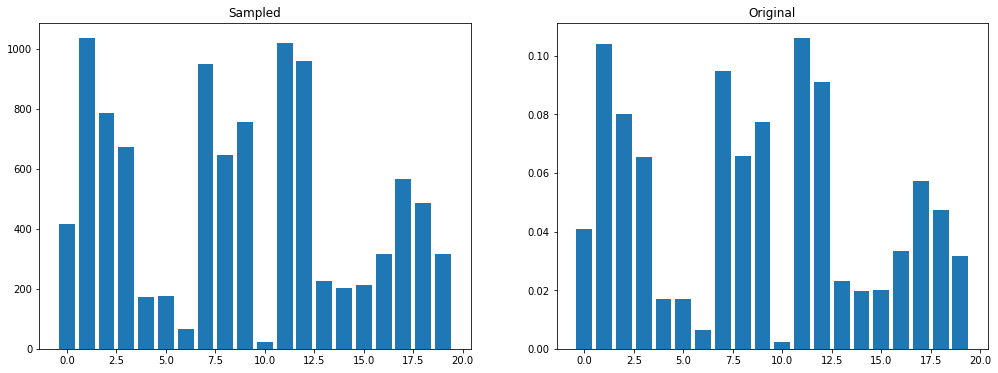

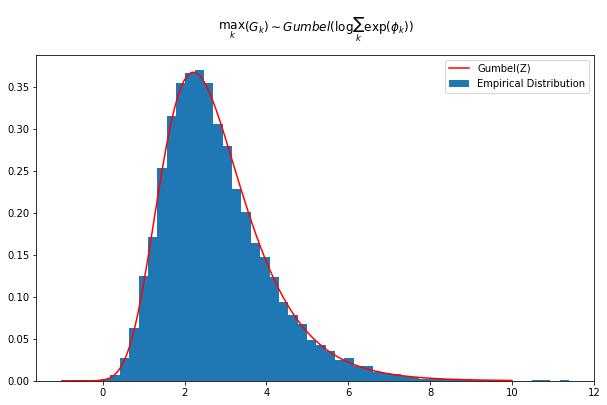

In [4]:
plt.figure(figsize=(17, 6))
plt.subplot(121)
plt.bar(np.arange(len(P)), argmax_samples)
plt.title("Sampled")

plt.subplot(122)
plt.bar(np.arange(20), P)
plt.title("Original")
plt.show()

# calculate log partition function
log_partition = logsumexp(phi)

gumbel_pdf = lambda x, mu: np.exp(-(x - mu) - np.exp(-(x - mu))) 

xs = np.linspace(-1, 10, 200)

plt.figure(figsize=(10, 6))
plt.plot(xs, gumbel_pdf(xs, log_partition), color='r', label='Gumbel(Z)')
plt.hist(max_samples, bins=50, density=True, label='Empirical Distribution')
plt.title("$\max_{k}(G_k) \sim Gumbel(\log\sum_k\exp(\phi_k))$\n")
plt.legend()
plt.show()

# A* sampling

In [5]:
# =================================================================================
# Gumbel related stuff
# =================================================================================

def gumbel_pdf(x, loc=0.):
    
    z = -(x - loc)
    return np.exp(z - np.exp(z))

def gumbel_cdf(x, loc=0.):
    
    z = -(x - loc)
    return np.exp(-np.exp(z))

def gumbel_inv_cdf(x, loc=0.):
    return -np.log(-np.log(x)) + loc

def gumbel_sample(loc=0., size=None):
    
    u = np.random.uniform(size=size)
    return gumbel_inv_cdf(u, loc=loc)

# =================================================================================
# Truncated Gumbel related stuff
# =================================================================================

def trunc_gumbel_pdf(x, trunc, loc=0.):
    
    z = -(np.minimum(x, trunc) - loc)
    
    return (x < trunc) * np.exp(z - np.exp(z) + np.exp(-trunc + loc))

def trunc_gumbel_cdf(x, trunc, loc=0.):
    
    z = -(x - loc)
    trunc_z = -(np.minimum(x, trunc) - loc)
    
    return np.exp(-np.exp(trunc_z) + np.exp(z))

def trunc_gumbel_inv_cdf(x, trunc, loc=0.):
    
    mean = loc - np.euler_gamma
    
    return -np.log(np.exp(-trunc + mean) - np.log(x)) + mean

def trunc_gumbel_sample(trunc, loc=0., size=None):
    
    u = np.random.uniform(size=size)
    return trunc_gumbel_inv_cdf(u, trunc=trunc, loc=loc)

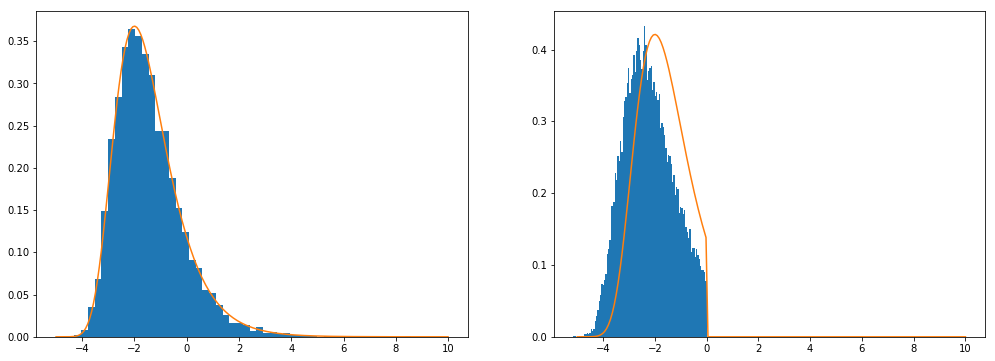

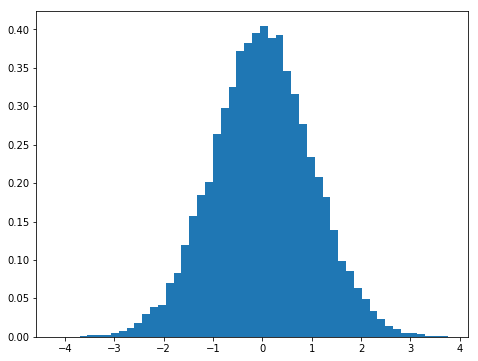

In [6]:
xs = np.linspace(-5, 10, 200)

plt.figure(figsize=(17,6))
plt.subplot(121)
plt.hist(gumbel_sample(size=10000, loc=-2.), bins=50, density=True)
plt.plot(xs, gumbel_pdf(xs, loc=-2.))

plt.subplot(122)
plt.hist(trunc_gumbel_sample(trunc=0., loc=-2., size=30000), bins=100, density=True)
plt.plot(xs, trunc_gumbel_pdf(xs, trunc=0., loc=-2.))
plt.show()

plt.figure(figsize=(17, 6))
plt.subplot(121)
plt.hist(truncnorm.ppf(np.random.uniform(size=30000), -np.inf, np.inf), bins=50, density=True)
plt.show()

In [59]:
# =================================================================================
# A* sampling
# =================================================================================

def a_star_sample(prop_trunc_samp, prop_log_mass, log_diff, region_bound, verbose=False):
    """
    prop_log_denisity - function taking 1 argument, is i(x) in the paper
    
    prop_log_mass - function taking 2 arguments a, b and calculates \log\int_a^b i(x) dx
    
    prop_trunc_samp - function taking 2 arguments a, b and samples from the truncated Gibbs
                      distribuiton of i(x), i.e. it samples X ~ exp(i(x))/Z where
                      x \in [a, b] and Z = \int_a^b exp(i(x)) dx
                      
    log_diff - function taking 1 argument, is o(x) in the paper
    
    region_bound - function taking 2 arguments a, b; is M(B) in the paper
    """
    
    def plot_samp(x, g, diff):
        plt.plot([x, x], [diff, diff + g], color='b')
        plt.scatter([x], [diff + g], color='b')
    
    # Initialisation
    lower_bound = -np.inf
    samp = None
    
    queue = []
    
    samp_idx = 0
    
    G = []
    X = []
    B = []
    M = []
    
    k = 0
    
    # First split:
    # generate maximum and maximum location
    b_1 = (-np.inf, np.inf)
    
    g_1 = gumbel_sample(loc=prop_log_mass(*b_1))
    x_1 = prop_trunc_samp(*b_1)
    
    m_1 = region_bound(*b_1)
    
    # Store G_1, X_1, B_1, M_1
    G.append(g_1)
    X.append(x_1)
    B.append(b_1)
    M.append(m_1)
    
    if verbose:
        plot_samp(x_1, g_1, log_diff(x_1))
        #plt.axhline(x_1 + g_1)
    
    hq.heappush(queue, (g_1 + m_1, 0))
    
    # Run A* search
    while len(queue) > 0 and lower_bound < queue[0][0]:
        
        # Get the bound with the highest priority
        _, p = hq.heappop(queue)
        
        # Calculate new proposed lower bound based on G_p
        lower_bound_p = G[p] + log_diff(X[p])
        
        # Check if the lower bound can be raised
        if lower_bound < lower_bound_p:
            
            lower_bound = lower_bound_p
            samp = X[p]
            samp_idx = p
            
#             if verbose:
#                 plt.axhline(lower_bound, linestyle='--', color='g')
            
        # Partition the space: split the current interval by X_p
        L = (B[p][0], X[p])
        R = (X[p], B[p][1])
        
        # Go down the heap / partitions
        for C in [L, R]:
            
            # TODO: check if this is a sufficiently good empty set condition
            if not C[0] == C[1]:  
                
                k += 1
                
                b_k = C
                g_k = trunc_gumbel_sample(loc=prop_log_mass(*C),
                                          trunc=G[p])
                x_k = prop_trunc_samp(*C)
                
                # Store B_k, G_k, X_k
                B.append(b_k)
                G.append(g_k)
                X.append(x_k)
                
                if verbose:
                    plot_samp(x_k, g_k, log_diff(x_k))
                
                # Check if there is a point in continuing the search along this path
                if lower_bound < g_k + M[p]:
                    m_k = region_bound(*b_k)
                    M.append(m_k)
                    
#                     if verbose:
#                         plt.plot([np.maximum(b_k[0], -20), np.minimum(b_k[1], 20)], 
#                                  [g_k + m_k] * 2, 
#                                  color='r', 
#                                  linestyle='--')
                    
                    if lower_bound < g_k + m_k:
                        hq.heappush(queue, (g_k + m_k, k))
                else:
                    # We push a non-informative bound here, so that the length of M 
                    # is the same as the rest
                    M.append(np.inf)
                    
    return lower_bound, samp, samp_idx

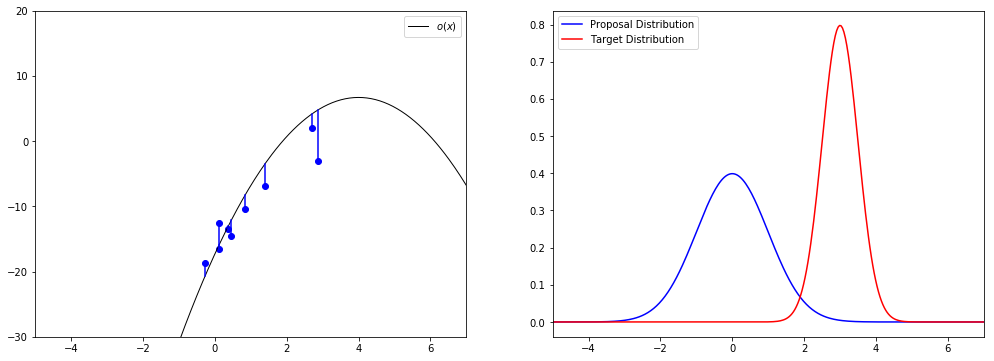

In [60]:
mu_prop = 0.
sigma_prop = 1.

mu_target = 3
sigma_target = 0.5

def normal_log_diff(x, mu_prop, sigma_prop, mu_target, sigma_target):

    return norm.logpdf(x, mu_target, sigma_target) - norm.logpdf(x, mu_prop, sigma_prop)
    
def normal_region_bound(a, b, mu_prop, sigma_prop, mu_target, sigma_target):
    #print((a, b))
    if a < mu_target < b:
        # The log difference attains its maximum here
        #max_x = (mu_prop * sigma_target**2 - mu_target * sigma_prop**2) / (sigma_target**2 - sigma_prop**2)

        return 7#normal_log_diff(max_x, mu_prop, sigma_prop, mu_target, sigma_target)
    else:
        # Both bounds can never be none, because the above branch will always get executed in the case
        # a = -inf, b = inf since the mean will always be in (-inf, inf)
        a_bound = None if a == -np.inf else normal_log_diff(a, mu_prop, sigma_prop, mu_target, sigma_target)
        b_bound = None if b == np.inf else normal_log_diff(b, mu_prop, sigma_prop, mu_target, sigma_target)
            
        if a_bound is None:    
            return b_bound
        elif b_bound is None:
            return a_bound
        else:
            return np.maximum(a_bound, b_bound)

xs = np.linspace(-5, 7, 300)

plt.figure(figsize=(17, 6))
plt.subplot(121)
plt.plot(xs, test_log_diff(xs), color='k', label="$o(x)$", linewidth=1)

res = a_star_sample(prop_trunc_samp=lambda a, b: truncnorm.ppf(np.random.uniform(), a, b), 
                            prop_log_mass=lambda a, b: np.log(norm.cdf(b) - norm.cdf(a)), 
                            log_diff=lambda x: normal_log_diff(x, mu_prop, sigma_prop, mu_target, sigma_target), 
                            region_bound=lambda a, b: normal_region_bound(a, b, mu_prop, sigma_prop, mu_target, sigma_target),
                            verbose=True)

plt.legend()
plt.ylim([-30, 20])
plt.xlim([-5, 7])

plt.subplot(122)
plt.plot(xs, norm.pdf(xs, mu_prop, sigma_prop), color='b', label="Proposal Distribution")
plt.plot(xs, norm.pdf(xs, mu_target, sigma_target), color='r', label="Target Distribution")
plt.legend()
plt.xlim([-5, 7])

plt.show()

In [81]:
# for reproducibility
np.random.seed(4)

samples = []
num_samples = 30000

indexed_samples = {k: [] for k in range(40)}

for i in tqdm(range(num_samples)):
    _, samp, samp_idx = a_star_sample(prop_trunc_samp=lambda a, b: truncnorm.ppf(np.random.uniform(), a, b), 
                            prop_log_mass=lambda a, b: np.log(norm.cdf(b) - norm.cdf(a)), 
                            log_diff=lambda x: normal_log_diff(x, mu_prop, sigma_prop, mu_target, sigma_target), 
                            region_bound=lambda a, b: normal_region_bound(a, b, mu_prop, sigma_prop, mu_target, sigma_target),
                            verbose=False)
    
    indexed_samples[samp_idx].append(samp)
    
    samples.append(samp)

30000
72


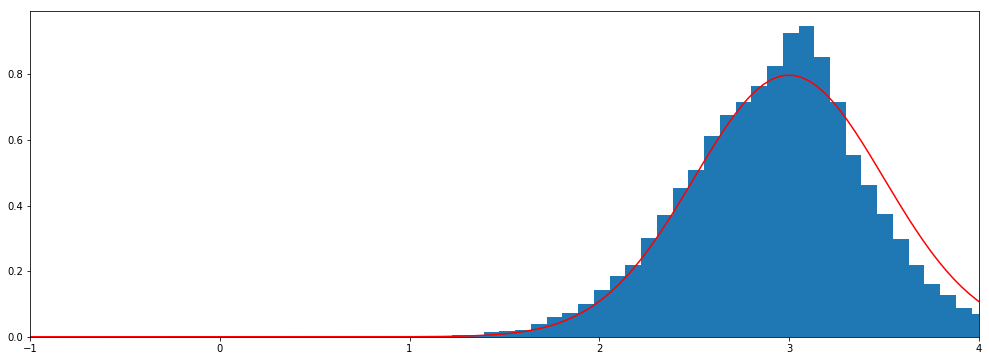

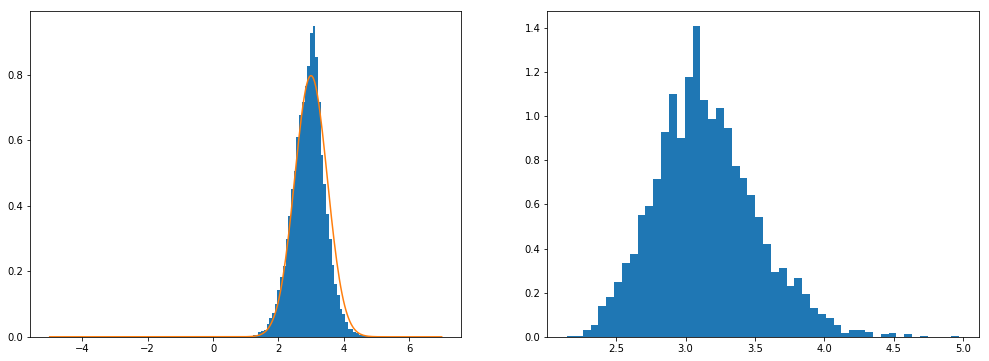

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])


In [91]:
print(len(samples))
print(len(first_samps))

plt.figure(figsize=(17, 6))
plt.hist(samples + first_samps, bins=50, density=True)
plt.plot(xs, norm.pdf(xs, mu_target, sigma_target), color='r', label="Target Distribution")
plt.xlim([-1, 4])
plt.show()

plt.figure(figsize=(17, 6))
plt.subplot(121)
plt.hist(samples, bins=50, density=True)
plt.plot(xs, norm.pdf(xs, 3, 0.5))

plt.subplot(122)
plt.hist(indexed_samples[14], bins=50, density=True)
#plt.plot(xs, gumbel_r.pdf(xs, 1.8, 0.3))
plt.show()

print(indexed_samples.keys())